 ### Problem Statement

User generated reviews for products has been a cornerstone for people’s interest in purchase.
However, the rise of the Large Language Model (LLM) has made generating these reviews
inexpensive, quick and trivial. This means the usage of LLM to generate fake reviews is on the
rise. The goal of this project is to build and explore different strategies for the classification
problems at hand: Statistical (Simple), Supervised Transformer based, and Self detection using
LLM. First one is based on statistical differences of the text generated by LLM as compared to
humans, with respect to attributes like token distribution and entropy and perplexity. This is
based on the notion that human generated text usually has higher perplexity than AI generated.
We plan to also experiment with the second approach where we fine tune transformer based
models to do the classification task. We compare the performances of above-mentioned
approaches. For the final strategy, we prompt LLM to self detect if the given text is generated by
AI or not.


### Data acquisition

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Dataset 1:  [Ai vs Human](https://www.kaggle.com/datasets/shanegerami/ai-vs-human-text?resource=download)

This dataset consist of labeled essays whether humman written or LLM generated.

##### Getting the dataset

Make sure to download the ai vs human  zip file from [kaggle](https://www.kaggle.com/datasets/shanegerami/ai-vs-human-text?resource=download), unzip it and upload a copy of AI_Human csv in google drive. Make sure to create the exact directory structure as in `csv_path` so all contributors can work with same version of this code.

In [2]:
import pandas as pd

csv_path = '/content/drive/MyDrive/Grad/NLP/FinalProject/AI_Human.csv'
df = pd.read_csv(csv_path)

df.info()     # column names + dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487235 entries, 0 to 487234
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   text       487235 non-null  object 
 1   generated  487235 non-null  float64
dtypes: float64(1), object(1)
memory usage: 7.4+ MB


##### Explore datasets

In [3]:
df_ai=df[df['generated']==1]
df_ai.info()
# df_ai.head()


<class 'pandas.core.frame.DataFrame'>
Index: 181438 entries, 704 to 487232
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   text       181438 non-null  object 
 1   generated  181438 non-null  float64
dtypes: float64(1), object(1)
memory usage: 4.2+ MB


In [4]:
df_ai.head(10)

,text,generated
704,"This essay will analyze, discuss and prove one...",1.0
740,I strongly believe that the Electoral College ...,1.0
1262,"Limiting car use causes pollution, increases c...",1.0
1378,Car-free cities have become a subject of incre...,1.0
1379,"Car Free Cities Car-free cities, a concept ga...",1.0
1380,A Sustainable Urban Future Car-free cities ...,1.0
1381,Pioneering Sustainable Urban Living In an e...,1.0
1382,The Path to Sustainable Urban Living In an ...,1.0
1383,A Paradigm Shift in Urban Living In an era ...,1.0
1384,Revolutionizing Urban Living In an age defi...,1.0


In [5]:
df_human=df[df['generated']==0]
df_human.info()

<class 'pandas.core.frame.DataFrame'>
Index: 305797 entries, 0 to 487234
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   text       305797 non-null  object 
 1   generated  305797 non-null  float64
dtypes: float64(1), object(1)
memory usage: 7.0+ MB


In [6]:
df_human.head(10)

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0
5,The electrol college system is an unfair syste...,0.0
6,"Dear state senator, It is the utmost respect t...",0.0
7,"Fellow citizens, cars have become a major role...",0.0
8,"""It's official: The electoral college is unfai...",0.0
9,The Electoral College has been kept for centur...,0.0


#### Dataset 2: [TuringBench dataset](https://www.kaggle.com/datasets/robikiso/turingbench-dataset?select=test.csv)


This dataset contains multilabelled dataset classified as `human` or specific LLM used to generate. Following labels are used for LLM generated: `gpt2_pytorch`, `gpt2_small`, `fair_wmt19`, `pplm_gpt2`, `gpt2_large`, `ctrl`, `xlm`, `gpt3`, `xlnet_base`, `transfo_xl`, `gpt2_xl`, `pplm_distil`, `gpt2_medium`, `grover_large`, `grover_mega`, `gpt1`, `grover_base`, `xlnet_large`, `fair_wmt20`.

##### Getting the dataset

Make sure to download 3 datasets (test.csv, train.csv and valid.csv) from [kaggle TuringBench dataset](https://www.kaggle.com/datasets/robikiso/turingbench-dataset?resource=download&select=test.csv), unzip it if needed and upload a copy of each of those files in your google drive.
Make sure it is located as:

In [27]:
csv_test_path='/content/drive/MyDrive/Grad/NLP/FinalProject/Turing_Bench/test.csv'
csv_train_path='/content/drive/MyDrive/Grad/NLP/FinalProject/Turing_Bench/train.csv'
csv_val_path='/content/drive/MyDrive/Grad/NLP/FinalProject/Turing_Bench/valid.csv'

df_tb_test = pd.read_csv(csv_test_path)
df_tb_train = pd.read_csv(csv_train_path)
df_tb_val = pd.read_csv(csv_val_path)

df_tb_test.info()
df_tb_train.info()
df_tb_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37357 entries, 0 to 37356
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Generation  37357 non-null  object
 1   label       37357 non-null  object
dtypes: object(2)
memory usage: 583.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112204 entries, 0 to 112203
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Generation  112204 non-null  object
 1   label       112204 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19051 entries, 0 to 19050
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Generation  19051 non-null  object
 1   label       19051 non-null  object
dtypes: object(2)
memory usage: 297.8+ KB


##### Explore Dataset

In [28]:
df_tb_train.head()

df_tb_train['label'].unique()

array(['gpt2_pytorch', 'gpt2_small', 'fair_wmt19', 'pplm_gpt2',
       'gpt2_large', 'ctrl', 'xlm', 'gpt3', 'xlnet_base', 'transfo_xl',
       'gpt2_xl', 'pplm_distil', 'gpt2_medium', 'grover_large',
       'grover_mega', 'human', 'gpt1', 'grover_base', 'xlnet_large',
       'fair_wmt20'], dtype=object)

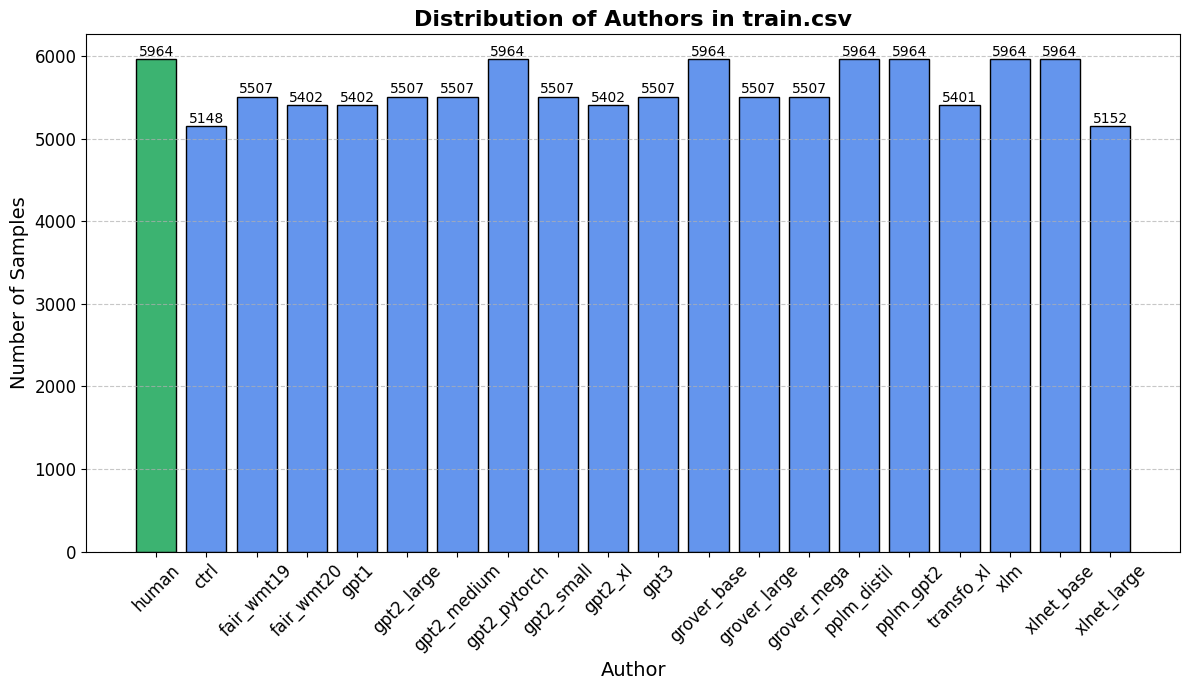

In [29]:
import matplotlib.pyplot as plt

# Count occurrences of each unique label
label_counts = df_tb_train['label'].value_counts()

# Reorder: put 'human' first, then the rest
label_counts = label_counts.loc[sorted(label_counts.index, key=lambda x: (x.lower() != 'human', x))]

# Assign colors: green for 'human', blue for others
colors = ['mediumseagreen' if label.lower() == 'human' else 'cornflowerblue' for label in label_counts.index]

# Plot the histogram
plt.figure(figsize=(12, 7))
bars = plt.bar(label_counts.index, label_counts.values, color=colors, edgecolor='black')

# Add counts on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 5, f'{int(height)}',
             ha='center', va='bottom', fontsize=10, fontweight='light')

# Styling
plt.title('Distribution of Authors in train.csv', fontsize=16, fontweight='bold')
plt.xlabel('Author', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Layout and show
plt.tight_layout()
plt.show()


##### Convert to compatible dataframe as in dataset 1

In [91]:
# Convert dataframe from Turing Bench to df compatible with 1st dataframe with (text and generation columns)
def convert_to_main_df(df_tb):
    # Filter only 'human' and 'gpt2_medium'
    df_filtered = df_tb[df_tb['label'].str.lower().isin(['human', 'gpt2_medium'])]

    return pd.DataFrame({
        'text': df_filtered['Generation'],
        'generated': df_filtered['label'].apply(lambda x: 0.0 if x.lower() == 'human' else 1.0)
    })

df_train_2=convert_to_main_df(df_tb_train)
df_test_2=convert_to_main_df(df_tb_test)
df_val_2=convert_to_main_df(df_tb_val)

In [92]:
df_train_2.shape[0]

11471

### Installing Common Libraries for Model Pretraining

In [7]:
!pip install -q datasets
!pip install -q transformers



### Logistic Regression Model using LLM features (Simple Model)

This is based on LLM features like Perplexity, Average Next token rank calculated from Pretrained GPT 2 Model

#### Pretrained GPT2 Model

In [8]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
import math

def load_model_and_tokenizer(model_name='gpt2', device=None):
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    model = GPT2LMHeadModel.from_pretrained(model_name)
    model.eval()
    model.to(device)

    return tokenizer, model

In [9]:
tokenizer, model= load_model_and_tokenizer('gpt2-medium')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

#### Feature 1: LLM perplexity

In [10]:
SAMPLE_SENTENCE="hey what's up?"

In [11]:
def calculate_perplexity(sentence, max_length=1024):
    inputs = tokenizer(sentence, return_tensors='pt',truncation=True, max_length=max_length)
    input_ids = inputs['input_ids']

    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids) # labels helps to compute loss
        loss = outputs.loss
        # print(outputs.logits)
        perplexity = torch.exp(loss)

    return perplexity.item()


In [12]:
calculate_perplexity(SAMPLE_SENTENCE)

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


70.79589080810547

#### Feature 2: Average Token Rank

At each position in the sentence:

- The model predicts a distribution of probabilities over the vocabulary for the next token.

- It sorts all possible tokens by probability.

- It checks the rank of the actual next token (i.e., where it appears in the sorted list).

- It repeats this for each token and returns the average rank over the sentence.



In [41]:
def get_avg_rank(sentence, max_length=1024):
    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, max_length=max_length)
    input_ids = inputs['input_ids']

    with torch.no_grad():
        outputs = model(input_ids)
        logits = outputs.logits

    ranks = []
    for i in range(1, input_ids.size(1)):
        true_token_id = input_ids[0, i]
        sorted_ids = torch.argsort(logits[0, i-1], descending=True)
        rank = (sorted_ids == true_token_id).nonzero(as_tuple=True)[0].item() + 1
        ranks.append(rank)

    return sum(ranks) / len(ranks) if ranks else None


In [42]:
get_avg_rank(SAMPLE_SENTENCE)

153.5

#### Feature 3: Average Entropy

In [77]:
import torch
import torch.nn.functional as F

def get_avg_entropy(sentence, max_length=1024):
    # Tokenize input
    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, max_length=max_length)
    input_ids = inputs['input_ids']

    with torch.no_grad():
        outputs = model(input_ids)
        logits = outputs.logits  # shape: [1, seq_len, vocab_size]

    # Compute softmax probabilities
    probs = F.softmax(logits, dim=-1)  # [1, seq_len, vocab_size]
    log_probs = F.log_softmax(logits, dim=-1)

    # Token-level entropy: H_t = -sum(p * log(p)) over vocab
    entropy = -(probs * log_probs).sum(dim=-1)  # shape: [1, seq_len]

    # Average entropy across tokens (excluding first token)
    avg_entropy = entropy[0, 1:].mean().item()

    return avg_entropy


In [78]:
get_avg_entropy(SAMPLE_SENTENCE)

5.081511974334717

#### Sample from dataset

We select equal but limited number of texts from AI generated and  human written for this purpose.

We call this `REVIEW_COUNT_PER_CATEGORY`

In [36]:
REVIEW_COUNT_PER_CATEGORY = 50

In [116]:
def sample_dataset(whole_df):

  df_combined2 = pd.concat([
      whole_df[whole_df['generated'] == 0.0].sample(n=REVIEW_COUNT_PER_CATEGORY, random_state=42),  # human
      whole_df[whole_df['generated'] == 1.0].sample(n=REVIEW_COUNT_PER_CATEGORY, random_state=42)   # AI
  ], ignore_index=True)

  df_combined2['label'] = df_combined2['generated'].astype(int)
  return df_combined2


In [117]:
# Use AI vs Human dataset
df_combined2 = sample_dataset(df)

# Use Turing Bench dataset
# df_combined2 = sample_dataset(df_train_2)

In [118]:
df_combined2.head()

,text,generated,label
0,Do curfews keep teenagers from Getting into tr...,0.0,0
1,"In this article ""The Challenge of Exploring Ve...",0.0,0
2,With THP rapid growth of THP Internet in recen...,0.0,0
3,The electoral College is the way Us United Sta...,0.0,0
4,This technology of you can calculate the emoti...,0.0,0


In [119]:
from tqdm import tqdm
tqdm.pandas()

def add_perplexity_as_feature(orig_df):
  orig_df['perplexity'] = orig_df['text'].progress_apply(calculate_perplexity)
  return orig_df

df_combined2 = add_perplexity_as_feature(df_combined2)


100%|██████████| 100/100 [02:39<00:00,  1.59s/it]


In [120]:
from tqdm import tqdm
tqdm.pandas()

def add_avg_token_rank_as_feature(orig_df):
  orig_df['avg_token_rank'] = orig_df['text'].progress_apply(get_avg_rank)
  return orig_df

df_combined2 = add_avg_token_rank_as_feature(df_combined2)


100%|██████████| 100/100 [05:58<00:00,  3.58s/it]


In [121]:
from tqdm import tqdm
tqdm.pandas()

def add_avg_entropy_as_feature(orig_df):
  orig_df['avg_entropy'] = orig_df['text'].progress_apply(get_avg_entropy)
  return orig_df

df_combined2 = add_avg_entropy_as_feature(df_combined2)

100%|██████████| 100/100 [02:40<00:00,  1.60s/it]


#### Exploratory data analysis

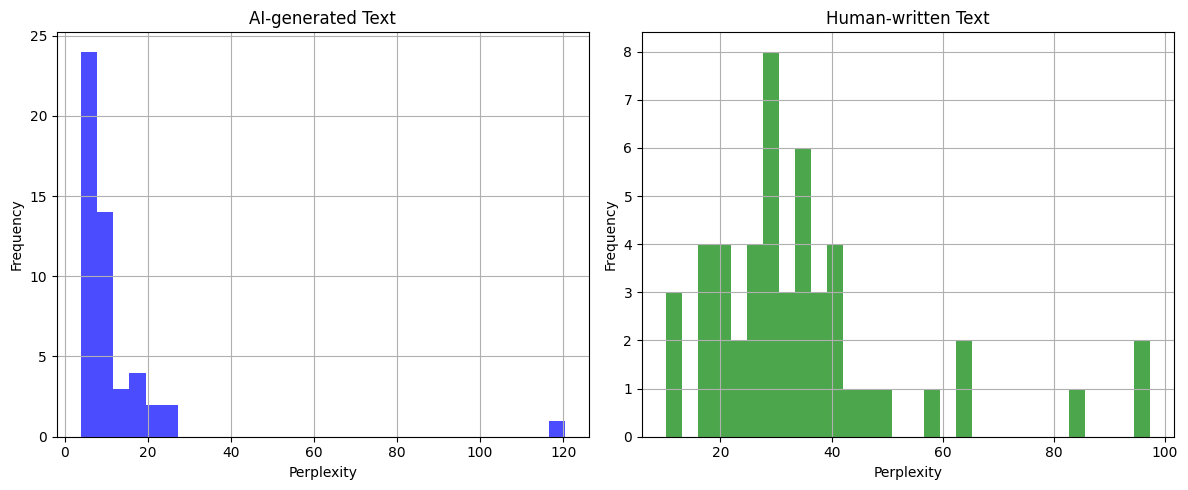

In [122]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot AI-generated text (generated == 1.0)
plt.subplot(1, 2, 1)
plt.hist(df_combined2[df_combined2['generated'] == 1.0]['perplexity'], bins=30, color='blue', alpha=0.7)
plt.title('AI-generated Text')
plt.xlabel('Perplexity')
plt.ylabel('Frequency')
plt.grid(True)

# Plot Human-written text (generated == 0.0)
plt.subplot(1, 2, 2)
plt.hist(df_combined2[df_combined2['generated'] == 0.0]['perplexity'], bins=30, color='green', alpha=0.7)
plt.title('Human-written Text')
plt.xlabel('Perplexity')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()


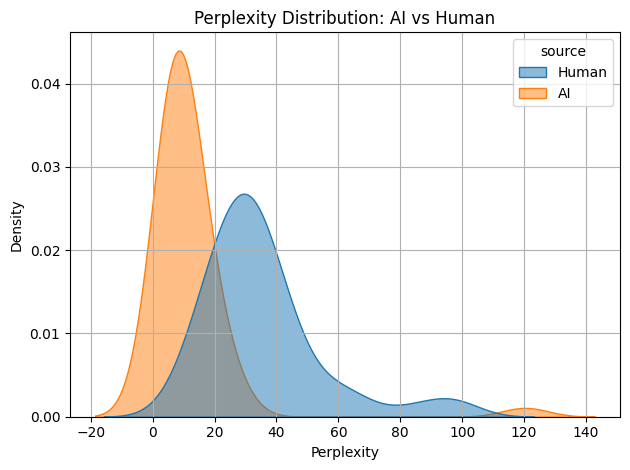

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt

df_kde=df_combined2
# Map 0.0 and 1.0 to 'Human' and 'AI'
df_kde['source'] = df_combined2['generated'].map({1.0: 'AI', 0.0: 'Human'})

# Plot KDE
sns.kdeplot(data=df_kde, x='perplexity', hue='source', fill=True, common_norm=False, alpha=0.5)
plt.title("Perplexity Distribution: AI vs Human")
plt.xlabel("Perplexity")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()


In [124]:
df_combined2.head()

,text,generated,label,perplexity,avg_token_rank,avg_entropy,source
0,Do curfews keep teenagers from Getting into tr...,0.0,0,30.938160,264.659379,3.818206,Human
1,"In this article ""The Challenge of Exploring Ve...",0.0,0,28.570618,97.792453,3.654914,Human
2,With THP rapid growth of THP Internet in recen...,0.0,0,38.817833,341.778813,4.051385,Human
3,The electoral College is the way Us United Sta...,0.0,0,26.983147,125.342172,3.612436,Human
4,This technology of you can calculate the emoti...,0.0,0,41.514854,268.528822,3.899520,Human


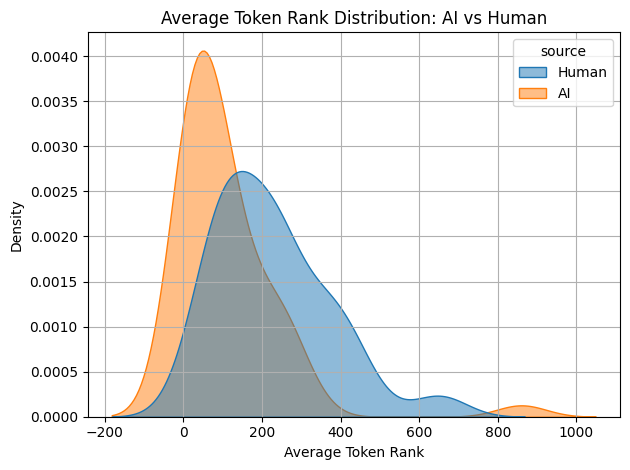

In [125]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare df_kde with the required column
df_kde = df_combined2[['avg_token_rank', 'generated']].copy()

# Map 0.0 and 1.0 to 'Human' and 'AI'
df_kde['source'] = df_kde['generated'].map({1.0: 'AI', 0.0: 'Human'})

# Plot KDE
sns.kdeplot(
    data=df_kde,
    x='avg_token_rank',
    hue='source',
    fill=True,
    common_norm=False,
    alpha=0.5
)

plt.title("Average Token Rank Distribution: AI vs Human")
plt.xlabel("Average Token Rank")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()


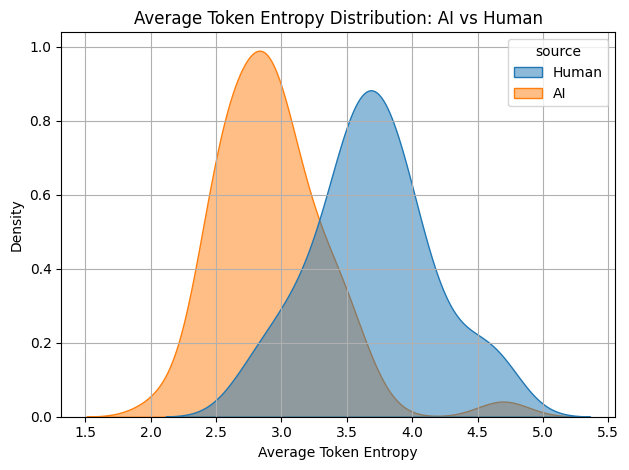

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare df_kde with the required column
df_kde = df_combined2[['avg_entropy', 'generated']].copy()

# Map 0.0 and 1.0 to 'Human' and 'AI'
df_kde['source'] = df_kde['generated'].map({1.0: 'AI', 0.0: 'Human'})

# Plot KDE
sns.kdeplot(
    data=df_kde,
    x='avg_entropy',
    hue='source',
    fill=True,
    common_norm=False,
    alpha=0.5
)

plt.title("Average Token Entropy Distribution: AI vs Human")
plt.xlabel("Average Token Entropy")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()


In [100]:
# df_combined2.to_csv('/content/drive/MyDrive/Grad/NLP/FinalProject/df_combined2.csv', index=False)

##### Scatterplot to see if linearly separable

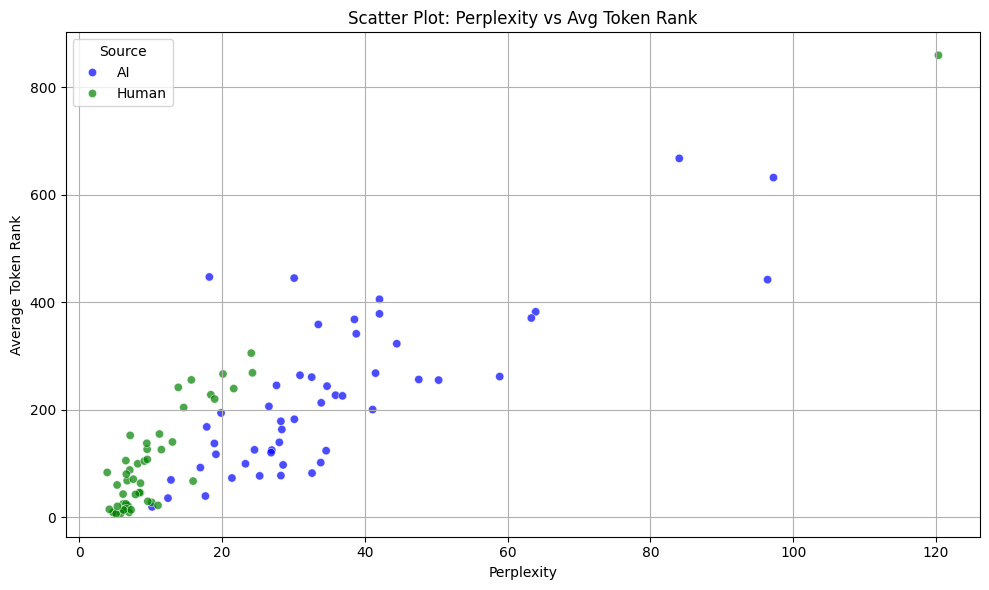

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt

# Map numeric label to text for color legend
df_combined2['label_text'] = df_combined2['label'].map({1: 'Human', 0: 'AI'})

# Create scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_combined2,
    x='perplexity',
    y='avg_token_rank',
    hue='label_text',
    alpha=0.7,
    palette={'Human': 'green', 'AI': 'blue'}
)

plt.title("Scatter Plot: Perplexity vs Avg Token Rank")
plt.xlabel("Perplexity")
plt.ylabel("Average Token Rank")
plt.legend(title="Source")
plt.grid(True)
plt.tight_layout()
plt.show()


#### Logistic Regression

In [128]:
df_combined2.shape[0]

100

Classification Report (All features):
               precision    recall  f1-score   support

           0       0.82      0.75      0.78        12
           1       0.67      0.75      0.71         8

    accuracy                           0.75        20
   macro avg       0.74      0.75      0.74        20
weighted avg       0.76      0.75      0.75        20

AUC Score: 0.7604166666666667


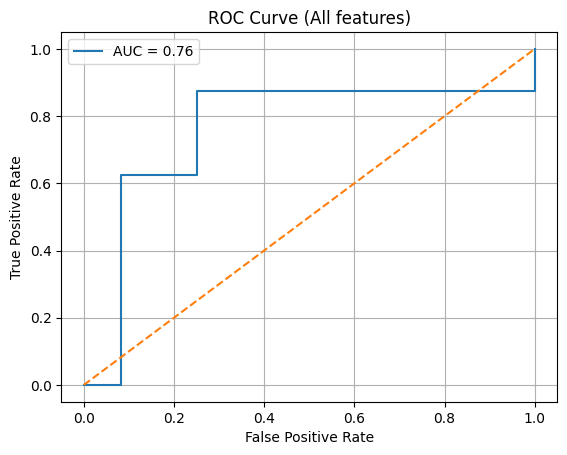

In [129]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt



def evaluate_model(X, y, title):
  # 2. Train-test split
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, random_state=42
  )

  # 3. Train logistic regression model
  clf = LogisticRegression()
  clf.fit(X_train, y_train)

  # 4. Predict
  y_pred = clf.predict(X_test)
  y_prob = clf.predict_proba(X_test)[:, 1]  # Probability that label = 1 (human)

  # 5. Evaluate model
  print(f"Classification Report ({title}):\n", classification_report(y_test, y_pred))
  print("AUC Score:", roc_auc_score(y_test, y_prob))

  # 6. ROC Curve
  fpr, tpr, _ = roc_curve(y_test, y_prob)
  plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.2f}")
  plt.plot([0, 1], [0, 1], linestyle='--')
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title(f"ROC Curve ({title})")
  plt.legend()
  plt.grid()
  plt.show()



# 1. Define features and labels
X = df_combined2[[ 'perplexity'
                    , 'avg_token_rank'
                    , 'avg_entropy'
                  ]]  # Use all features
y = df_combined2['label']  # 1 = human, 0 = AI
evaluate_model(X,y, 'All features')

In [132]:
X_perplexity = df_combined2[['perplexity']]
X_rank = df_combined2[['avg_token_rank']]
X_entropy = df_combined2[['avg_entropy']]

Classification Report (Perplexity):
               precision    recall  f1-score   support

           0       0.79      0.92      0.85        12
           1       0.83      0.62      0.71         8

    accuracy                           0.80        20
   macro avg       0.81      0.77      0.78        20
weighted avg       0.80      0.80      0.79        20

AUC Score: 0.8333333333333334


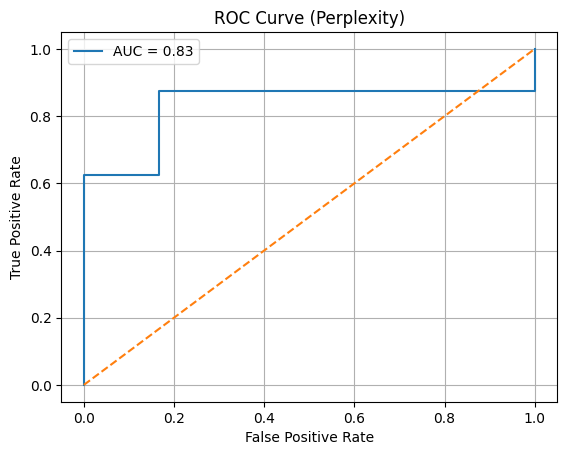

Classification Report (Average Token Rank):
               precision    recall  f1-score   support

           0       0.73      0.67      0.70        12
           1       0.56      0.62      0.59         8

    accuracy                           0.65        20
   macro avg       0.64      0.65      0.64        20
weighted avg       0.66      0.65      0.65        20

AUC Score: 0.71875


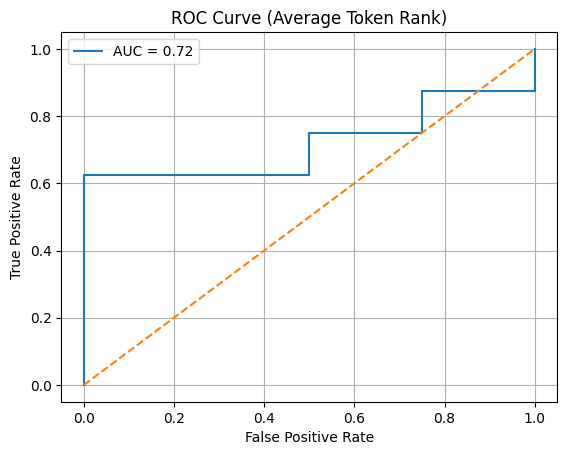

Classification Report (Average Token Entropy ):
               precision    recall  f1-score   support

           0       0.83      0.83      0.83        12
           1       0.75      0.75      0.75         8

    accuracy                           0.80        20
   macro avg       0.79      0.79      0.79        20
weighted avg       0.80      0.80      0.80        20

AUC Score: 0.8125000000000001


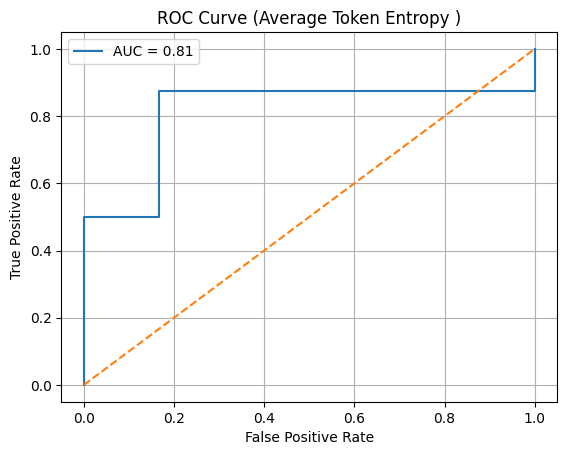

In [133]:
evaluate_model(X_perplexity, y, 'Perplexity')
evaluate_model(X_rank, y,'Average Token Rank')
evaluate_model(X_entropy, y,'Average Token Entropy ')

### BERT Model

In [ ]:
# Import libraries
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128
    )


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Stratified 30k sample
df_sampled, _ = train_test_split(
    df,
    train_size=30000,
    stratify=df['generated'],
    random_state=42
)

# Confirm class balance
print(df_sampled['generated'].value_counts(normalize=True))


generated
0.0    0.627633
1.0    0.372367
Name: proportion, dtype: float64


In [ ]:
# Save for future reuse
df_sampled.to_csv('/content/drive/MyDrive/NLP_Final/df_sampled.csv', index=False)

In [ ]:
# Get the disjoint set (remaining ~570k examples)
remaining_df = df.drop(df_sampled.index)

# Sample a 3k test set from it, also stratified
test_df, _ = train_test_split(
    remaining_df,
    train_size=3000,
    stratify=remaining_df['generated'],
    random_state=24
)

# Optional: Confirm class balance in test set
print(test_df['generated'].value_counts(normalize=True))


generated
0.0    0.627667
1.0    0.372333
Name: proportion, dtype: float64


In [ ]:
test_df.to_csv('/content/drive/MyDrive/NLP_Final/test_disjoint.csv', index=False)

In [ ]:
# 80/20 split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_sampled['text'], df_sampled['generated'],
    test_size=0.2,
    random_state=42
)


In [ ]:
# Convert to Hugging Face datasets
train_dataset = Dataset.from_dict({'text': train_texts, 'label': train_labels})
val_dataset = Dataset.from_dict({'text': val_texts, 'label': val_labels})

# Tokenize with multiprocessing
train_dataset = train_dataset.map(tokenize_function, batched=True, num_proc=4)
val_dataset = val_dataset.map(tokenize_function, batched=True, num_proc=4)

Map (num_proc=4):   0%|          | 0/24000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


Map (num_proc=4):   0%|          | 0/6000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [ ]:
# Step 1: Rename label column to match train/val format
test_df = test_df.rename(columns={'generated': 'label'})

# Step 2: Convert to Hugging Face Dataset
test_dataset = Dataset.from_dict({
    'text': test_df['text'].tolist(),
    'label': test_df['label'].tolist()
})

# Step 3: Tokenize with multiprocessing
test_dataset = test_dataset.map(tokenize_function, batched=True, num_proc=4)

# Step 4: Ensure labels are integers (fix for NumPy 2.0)
test_dataset = test_dataset.map(lambda x: {'label': [int(v) for v in x['label']]}, batched=True)

# Step 5: Set format for PyTorch usage
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


Map (num_proc=4):   0%|          | 0/3000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [ ]:
# Load pre-trained BERT model with classification head
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    save_strategy='epoch',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=10,
    load_best_model_at_end=True,
    report_to='none'  # disables wandb and other integrations
    # metric_for_best_model='accuracy'  # optional, add if using compute_metrics
)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
from transformers import Trainer
import torch.nn as nn

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        labels = labels.long()
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

NameError: name 'train_dataset' is not defined

In [ ]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.001000,0.049072,0.988500,0.984615,0.978723,0.990579
2,0.052100,0.060392,0.987667,0.983556,0.974461,0.992822


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.001000,0.049072,0.988500,0.984615,0.978723,0.990579
2,0.052100,0.060392,0.987667,0.983556,0.974461,0.992822
3,0.000400,0.055265,0.989000,0.985366,0.974134,0.996860


TrainOutput(global_step=4500, training_loss=0.04404380644249937, metrics={'train_runtime': 1686.4756, 'train_samples_per_second': 42.693, 'train_steps_per_second': 2.668, 'total_flos': 4735998996480000.0, 'train_loss': 0.04404380644249937, 'epoch': 3.0})

In [ ]:
trainer.evaluate()


{'eval_loss': 0.049072153866291046,
 'eval_accuracy': 0.9885,
 'eval_f1': 0.9846153846153847,
 'eval_precision': 0.9787234042553191,
 'eval_recall': 0.990578734858681,
 'eval_runtime': 40.2985,
 'eval_samples_per_second': 148.889,
 'eval_steps_per_second': 9.306,
 'epoch': 3.0}

In [ ]:
test_metrics = trainer.evaluate(eval_dataset=test_dataset)
print(test_metrics)


ValueError: Unable to avoid copy while creating an array as requested.
If using `np.array(obj, copy=False)` replace it with `np.asarray(obj)` to allow a copy when needed (no behavior change in NumPy 1.x).
For more details, see https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword.

In [ ]:
model.save_pretrained('/content/drive/MyDrive/NLP_Final/bert-ai-vs-human')
tokenizer.save_pretrained('/content/drive/MyDrive/NLP_Final/bert-ai-vs-human')

('/content/drive/MyDrive/NLP_Final/bert-ai-vs-human/tokenizer_config.json',
 '/content/drive/MyDrive/NLP_Final/bert-ai-vs-human/special_tokens_map.json',
 '/content/drive/MyDrive/NLP_Final/bert-ai-vs-human/vocab.txt',
 '/content/drive/MyDrive/NLP_Final/bert-ai-vs-human/added_tokens.json')

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer

model_path = '/content/drive/MyDrive/NLP_Final/bert-ai-vs-human'

model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)


RuntimeError: Failed to import transformers.models.bert.modeling_bert because of the following error (look up to see its traceback):
module 'numpy' has no attribute 'dtypes'

In [ ]:
import pandas as pd

test_df = pd.read_csv('/content/drive/MyDrive/NLP_Final/test_disjoint.csv')
test_df = test_df.rename(columns={'generated': 'label'})  # if needed


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    tokenizer=tokenizer
)


<ipython-input-17-b1796d655e3b>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Step 1: Make sure labels are int
test_df['label'] = test_df['label'].astype(int)

# Step 2: Convert to Hugging Face Dataset
from datasets import Dataset
test_dataset = Dataset.from_pandas(test_df)

# Step 3: Tokenize (with multiprocessing)
test_dataset = test_dataset.map(tokenize_function, batched=True, num_proc=4)

# Step 4: Remove unnecessary columns if present
if 'text' in test_dataset.column_names:
   columns_to_remove = [col for col in ['text', '__index_level_0__'] if col in test_dataset.column_names]
   test_dataset = test_dataset.remove_columns(columns_to_remove)


# Step 5: Use with_format (this avoids numpy crash)
test_dataset = test_dataset.with_format('torch')



Map (num_proc=4):   0%|          | 0/3000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [ ]:
test_metrics = trainer.evaluate(eval_dataset=test_dataset)
print(test_metrics)


ValueError: Unable to avoid copy while creating an array as requested.
If using `np.array(obj, copy=False)` replace it with `np.asarray(obj)` to allow a copy when needed (no behavior change in NumPy 1.x).
For more details, see https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword.

In [ ]:
!pip install numpy==1.24.4 --force-reinstall


  Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.
blosc2 3.3.2 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you h